<a href="https://colab.research.google.com/github/AnnaSkarpalezou/Portfolio-Optimization-using-Machine-Learning/blob/main/Full_Model_Stock_Prediction_%2B_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU Available?

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7355500274998882203
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14808276749816053120
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11274053810922657387
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15473775744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5214844459976668040
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


### Data Pulling

In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [ ]:
#This part linkes the dataset in the drive to the google colab file
link = 'https://drive.google.com/file/d/1GEsalW5I7kD50HaBdUgUZSk1d3qBM1Z5/view?usp=sharing'
id = link.split('/')[-2]
downloaded = drive.CreateFile({'id' : id})
downloaded.GetContentFile('StockPrices.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('StockPrices.csv')
df['Date']= pd.to_datetime(df['Date'])
df_close = df[['Date', 'Index', 'Close']] 
df_close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275516 entries, 0 to 2275515
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   Index   object        
 2   Close   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 52.1+ MB


## Stock Prices

In [ ]:
df_close = df_close.pivot_table(index = 'Date',columns = 'Index').dropna(axis = 'columns')

In [ ]:
df_close #Removal of Unneccessary Stocks

Close              ...                       
Index                A        AAPL  ...        ZBRA       ZION
Date                                ...                       
2000-11-03   33.485336    0.397321  ...   20.194445  57.437500
2000-11-06   33.172390    0.382813  ...   20.055555  57.875000
2000-11-07   32.859444    0.380580  ...   20.388889  57.375000
2000-11-08   31.741774    0.358259  ...   20.027779  57.750000
2000-11-09   31.160587    0.360491  ...   20.583334  56.875000
...                ...         ...  ...         ...        ...
2020-10-22  106.769997  115.750000  ...  300.910004  32.250000
2020-10-23  106.169998  115.040001  ...  303.720001  33.200001
2020-10-26  104.629997  115.050003  ...  295.100006  32.459999
2020-10-27  106.040001  116.599998  ...  289.279999  31.080000
2020-10-28  101.660004  111.199997  ...  285.200012  30.600000

[5027 rows x 382 columns]

In [ ]:
#Saving Trading Days
dates = df_close.index

#Saving Stocks
stocks = df_close.droplevel(0,1).columns

### Data Manipulation
- Training/Testing Data
- Scaling the data (MinMaxScaler)

### Training/ Validation/ Test Set + Scaling the Data 

In [ ]:
from sklearn.model_selection import train_test_split
#Division of data
# df_close = df_close.to_numpy()
array_train, array_test = train_test_split(df_close, shuffle = False)

In [ ]:
array_train.shape

(3770, 382)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array_train = scl.fit_transform(array_train)
array_test  = scl.fit_transform(array_test)

# LSTM Stock Prediction

### Model Approach

In [ ]:
#Get the data and splits in input X and output Y, by spliting in lookback number of past days as input X 
#and horizon number of coming days as Y.
def processData(data, lookback, horizon,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -lookback - horizon +1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X),np.array(Y)

In [ ]:
num_companies = df_close.shape[1]
lookback = 252 #How many days of the past can the model see
horizon = 30 #How many days into the future are we trying to predict

In [ ]:
# Formation of lookback dataframes and forward dataframes for training, and testing dataset
# to calculate accuracy

X_test,y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,lookback,horizon,num_companies)
y = np.array([list(x.ravel()) for x in y])

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(2791, 252, 382)
(698, 252, 382)
(33, 252, 382)
(2791, 11460)
(698, 11460)
(33, 11460)


### Training the LSTM

In [ ]:
?LSTM

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dense,Activation,Attention

#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 = 600
num_neurons_L2 = 100
EPOCHS = 2

#Model
model = Sequential()

model.add(LSTM(num_neurons_L1,input_shape=(lookback,num_companies), return_sequences=True))
model.add(LSTM(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.add(Dense(horizon * num_companies))
#model.add(Attention(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(X_train,y_train,epochs=EPOCHS,
                    validation_data=(X_validate,y_validate),
                    shuffle=True,batch_size=1, verbose=2)

Epoch 1/2
2791/2791 - 71s - loss: 0.0085 - val_loss: 0.0052
Epoch 2/2
2791/2791 - 73s - loss: 0.0033 - val_loss: 0.0030


### Training loss

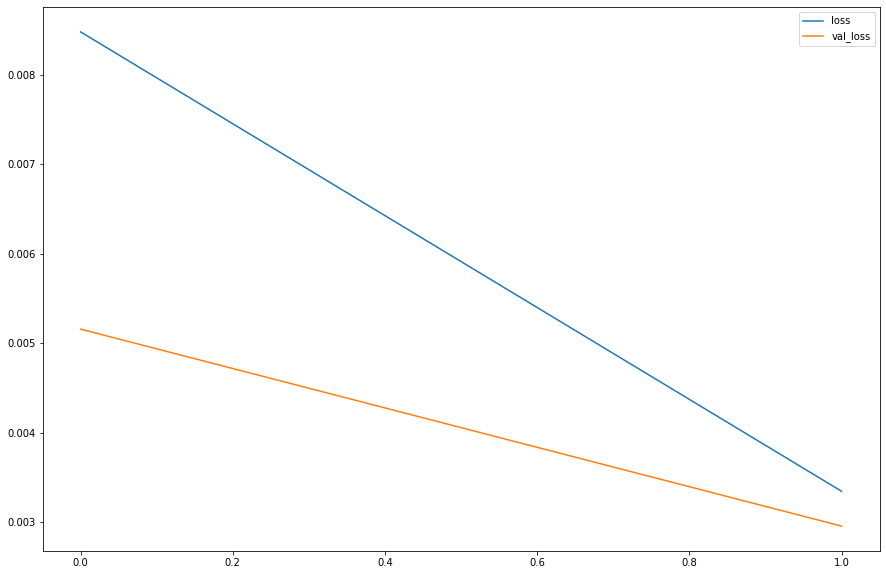

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

### Predicting Test Results

In [ ]:
X_test,y_test = processData(array_test,lookback,horizon,num_companies,horizon)
y_test = np.array([list(a.ravel()) for a in y_test])

Xt = model.predict(X_test)
Xt.shape

(33, 11460)

### Un-scaling the data
Because the results were scaled to train the model, the output is non sensible until we return the data into its original form

In [ ]:
def do_inverse_transform(output_result,num_companies):
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [ ]:
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)
predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(382, 33, 30)

In [ ]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [ ]:
Yt = do_inverse_transform(y_test, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(382, 990)

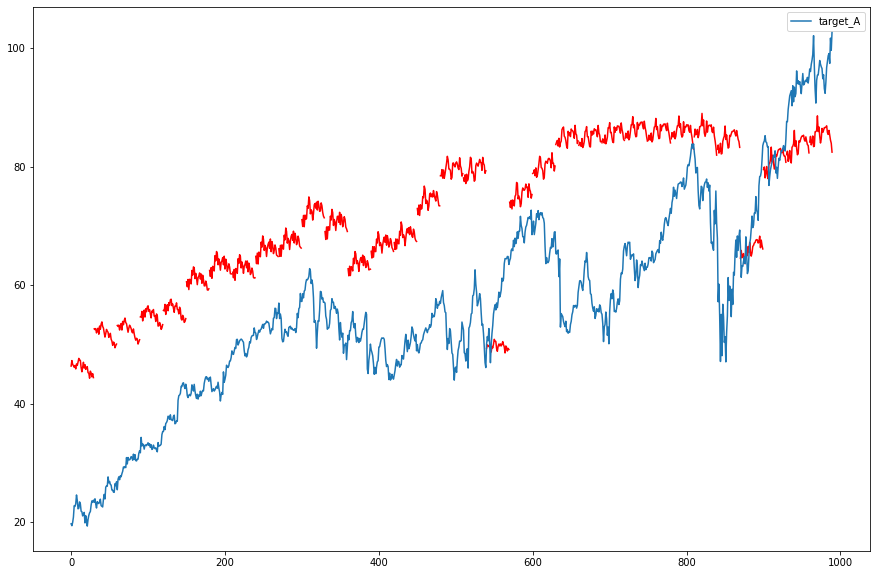

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [0] #select one of [0,1,2,3] to see only one
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']
 
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    # plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [ ]:
X_all,y_all = processData(scl.fit_transform(df_close),lookback,horizon,num_companies,horizon)
y_all = np.array([list(a.ravel()) for a in y_all])

In [ ]:
Xt = model.predict(X_all)
Xt.shape

(159, 11460)

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)

predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape


(382, 159, 30)

In [ ]:
Yt = do_inverse_transform(y_all, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(382, 4770)

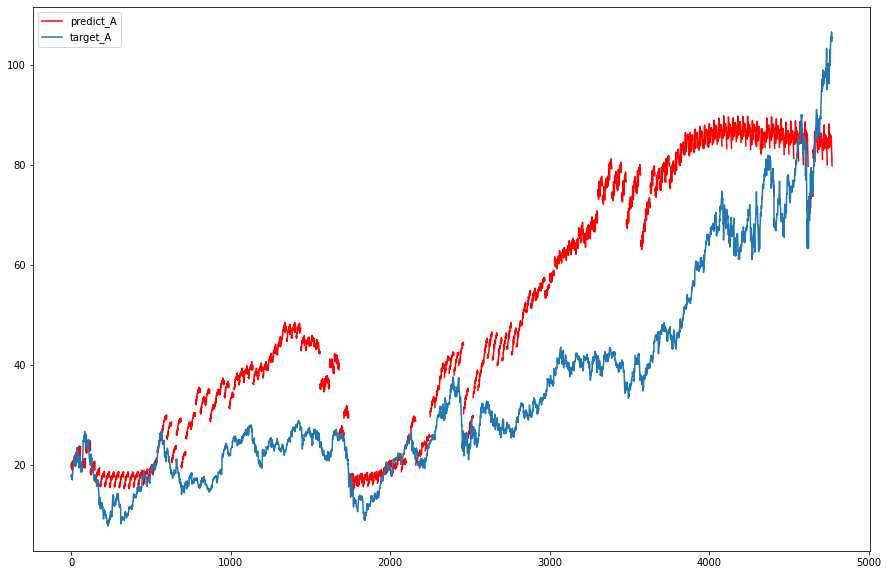

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [0]#select one of [0,1,2,3] to see only one
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']

    
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [ ]:
predicted_prices = np.zeros((predictions.shape[1]*predictions.shape[2],predictions.shape[0]))
# actual_prices = []

for i in range(predictions.shape[0]):
  counter = 0
  for j in range(predictions.shape[1]):
    for z in range(predictions.shape[2]):
      predicted_prices[counter, i] = predictions[i,j,z]
      counter+=1

print(counter)

4770


In [ ]:
predicted_prices = pd.DataFrame(data = predicted_prices,columns=stocks, index = dates[lookback+5:])#.replace(0, np.nan)#.iloc[:4992]
actual_prices = pd.DataFrame(data = actuals.T, columns = stocks,index = dates[lookback+5:])

In [ ]:
predicted_prices

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-11-16,20.206989,3.738951,18.615896,18.107983,28.154856,28.040916,39.859932,12.610086,50.369724,9.420076,58.536015,39.287937,3.505992,21.746431,1237.472534,38.860123,52.143459,-2.738288,18.203175,4.819393,53.157631,2.537176,28.056450,16.610418,7.175236,59.272797,5.176383,55.065968,16.083305,33.833122,6.221759,13.280764,51.180794,6.306292,42.372097,23.533274,4.566500,39.868656,116.423325,35.597572,...,7.461660,17.726767,21.373220,34.369972,27.749382,20.104528,77.173195,15.329568,23.886589,27.831289,12.362045,6.351552,34.682762,24.275265,18.837006,33.089588,11.232456,37.028721,8.181134,24.604881,32.196877,5.556333,11.085096,26.692123,24.576788,52.544289,28.321348,4.745089,69.204628,10.127096,6.795636,48.477718,21.135012,34.808384,35.604900,18.236345,18.520359,11.728664,28.856470,41.801361
2001-11-19,19.650322,3.231556,18.611002,16.316343,28.127701,29.941067,40.618107,12.558850,50.321556,12.462226,58.436558,39.473934,2.960556,21.558186,1228.937988,38.357491,52.868790,-1.167792,17.337862,4.414015,54.530579,2.998881,28.106197,16.406006,6.979581,58.292469,4.207704,97.173637,15.051596,35.649952,6.701398,14.689585,50.934544,6.535931,43.099201,23.645096,4.125988,39.691917,117.515465,37.023743,...,11.282591,17.670366,21.411966,34.385933,28.116617,21.027132,76.649612,16.618837,23.859314,27.509428,12.750717,7.535496,35.351841,23.807810,16.659695,33.517014,11.848972,37.205948,8.536515,25.697563,32.337387,5.582447,11.506410,27.199831,24.865879,52.933369,29.403320,4.461592,68.748688,9.955477,5.402029,49.541157,20.905085,33.769138,35.545872,18.484455,18.987564,11.391561,31.717270,41.633400
2001-11-20,19.462656,3.508345,17.532757,17.014881,28.147902,31.759052,40.306141,12.570020,49.462666,11.513803,57.754242,38.998501,2.732240,21.070139,1224.693481,38.372894,51.845470,-2.026146,16.675467,4.430318,53.454800,2.396908,28.212505,16.871769,7.168658,58.832714,2.850986,95.183846,15.032646,34.665337,5.943185,12.488488,52.374023,6.382512,41.551945,23.741869,3.689025,39.882740,116.978706,34.352230,...,9.024299,17.923782,22.240589,33.602165,27.896269,19.432404,76.044991,16.334429,23.589409,26.530451,12.702378,7.164490,35.490730,23.647532,16.358213,33.986290,10.847177,36.473335,7.145631,25.493776,31.352730,5.666678,11.539236,26.743198,24.241570,50.424870,28.563320,4.578397,68.290901,10.095732,7.072841,48.332039,20.133471,33.541996,34.902287,18.061798,18.810896,12.318525,32.093365,41.623653
2001-11-21,19.699577,3.782559,17.406424,13.592373,27.715914,27.818640,39.746956,12.361562,47.919018,12.101316,57.772415,38.731205,2.994665,21.025993,1241.364502,37.914021,51.894459,-3.452072,17.679630,5.037784,53.814217,3.002702,27.211275,15.878894,6.781731,57.960594,1.842208,60.207394,12.230104,33.994087,6.466401,12.973162,50.455898,7.040744,41.354641,23.541510,4.064490,39.930000,116.113380,34.819221,...,6.797503,17.522068,21.759859,31.434441,27.955938,20.436899,76.153946,17.036011,23.549690,27.430071,12.235068,7.523967,34.960785,24.051226,15.275310,31.678890,11.359900,36.675678,7.680803,27.185862,31.287024,5.268966,11.200356,26.773804,24.831207,49.145481,29.073441,4.391216,67.903923,9.992064,7.182734,48.060688,19.717638,32.358761,34.904236,18.011652,18.537214,10.758157,31.808016,41.837948
2001-11-23,20.103252,4.554537,16.729507,14.284554,27.225550,28.958076,39.605942,12.262531,49.846241,12.942351,58.099060,39.213085,2.859955,21.305479,1237.341431,38.454987,52.026955,-2.805844,17.887182,5.658334,54.316189,2.587456,27.987791,17.066330,7.268940,60.616531,4.879205,89.035942,13.705273,34.560593,6.305445,11.948047,49.226505,6.965295,41.542107,24.665

In [ ]:
actual_prices

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-11-16,17.739628,0.334107,14.000000,21.750000,23.881527,14.395000,44.250000,14.470000,43.095104,8.605000,42.259998,44.540001,13.870000,12.575000,1593.800049,43.150002,34.590000,4.000000,10.395000,6.382500,31.770000,4.712500,19.285000,12.390000,4.275556,56.889999,6.440000,7.120000,5.552500,34.509998,2.741667,22.640692,39.454208,5.910000,39.099998,20.940001,3.147500,46.400002,51.599998,28.631063,...,3.510000,14.150000,19.450001,15.882500,23.969999,13.455000,53.410000,20.540001,18.100000,15.678972,8.677025,9.021937,43.540001,29.461884,42.830002,26.059999,13.783259,45.128017,6.065000,38.099998,32.230000,4.070000,11.500000,25.879999,21.174999,61.709999,27.520000,24.292959,55.099998,7.142716,6.090000,51.849998,29.700001,36.029999,40.250000,14.773334,18.181818,9.149892,21.888889,48.740002
2001-11-19,17.625179,0.334821,14.197500,22.170000,24.065577,14.500000,45.310001,14.830000,43.396465,8.537500,42.070000,44.150002,14.120000,12.510000,1596.000000,43.680000,33.680000,4.430000,10.425000,6.300000,31.809999,5.075000,19.480000,12.800000,4.306667,56.270000,6.300000,7.050000,5.562500,34.139999,2.813333,22.307360,38.871414,6.000000,39.410000,21.180000,3.247500,46.700001,51.009998,28.088377,...,3.450000,14.270000,20.000000,16.105000,23.900000,13.375000,53.139999,20.410000,17.969999,15.928888,8.573446,9.060786,43.720001,29.322878,43.830002,25.430000,13.783259,44.516476,6.125000,38.230000,32.480000,4.230000,11.495000,25.680000,21.309999,62.240002,27.260000,24.081009,55.580002,7.183539,6.117500,51.290001,29.389999,37.000000,40.060001,14.703333,18.102766,9.133717,22.982222,48.230000
2001-11-20,17.846924,0.345893,14.250000,22.200001,23.845615,15.335000,47.419998,14.950000,43.959541,9.005000,42.150002,44.480000,14.810000,12.445000,1618.000000,44.000000,34.320000,5.100000,10.565000,6.700000,32.299999,5.425000,20.400000,13.650000,4.340741,57.990002,6.410000,7.290000,5.935000,34.840000,2.816667,22.138529,39.787235,6.065000,40.290001,21.020000,3.282500,47.630001,52.560001,28.140896,...,3.440000,14.340000,20.150000,16.237499,24.360001,13.430000,54.240002,20.500000,18.200001,16.244572,8.818268,9.117916,45.009998,29.505779,46.029999,27.150000,13.703323,43.967888,6.300000,39.040001,33.119999,4.270000,11.560000,25.709999,21.219999,63.169998,27.719999,24.610888,54.259998,7.240165,6.115000,51.770000,29.450001,38.500000,40.500000,14.683333,18.708828,9.207405,23.288889,48.099998
2001-11-21,18.104435,0.350179,13.775000,19.139999,23.423649,15.670000,46.700001,15.050000,44.284698,8.832500,41.110001,43.509998,14.940000,12.505000,1624.800049,44.430000,34.139999,5.730000,10.715000,6.900000,31.650000,5.237500,20.355000,14.000000,4.481482,57.330002,7.000000,9.490000,6.062500,34.720001,2.925000,20.870131,40.536541,6.067500,41.080002,21.219999,3.167500,47.349998,53.360001,29.261278,...,3.490000,14.400000,20.500000,16.260000,24.469999,13.362500,54.230000,20.549999,18.240000,15.953003,9.169021,8.775137,44.880001,29.271666,46.750000,27.150000,13.806098,44.291645,6.345000,37.990002,34.509998,4.380000,11.210000,25.400000,21.170000,65.059998,27.219999,23.624496,55.279999,7.105844,6.140000,53.830002,28.740000,37.790001,38.700001,14.546667,18.498024,9.180446,23.040001,48.169998
2001-11-23,17.904148,0.347321,13.860000,18.070000,23.746857,15.885000,45.650002,15.060000,44.411591,8.487500,40.419998,42.950001,15.900000,12.710000,1639.000000,44.990002,33.840000,5.850000,10.805000,6.727500,32.090000,5.200000,19.545000,13.750000,4.438519,57.040001,7.600000,9.050000,5.687500,34.900002,2.933333,18.982683,41.184090,6.087500,41.099998,21.049999,2.962500,47.779999,54

# Changes we could make

- Add more neurons per layer or reduce layers
- Others?

# Next Steps
- Plug our data into scipy opt/ GD / Montecarlo to predict weights
- *Which performs better; historical mean returns or predicted stock prices?*

# Converting Prices to Returns

### Actual Returns
These are the actual stock returns that the market experienced

In [ ]:
#Conversion of Actual Prices to Actual Returns
actual_returns = actual_prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:]  #Log returns minus first date
actual_returns

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-11-19,-0.006473,0.002135,0.014009,0.019126,0.007677,0.007268,0.023672,0.024575,0.006969,-0.007875,-0.004506,-0.008795,0.017864,-0.005182,0.001379,0.012208,-0.026660,0.102105,0.002882,-0.013010,0.001258,0.074108,0.010061,0.032555,0.007250,-0.010958,-0.021979,-0.009880,0.001799,-0.010779,0.025804,-0.014832,-0.014882,0.015114,0.007897,0.011396,0.031277,0.006445,-0.011500,-0.019136,...,-0.017242,0.008445,0.027885,0.013912,-0.002925,-0.005963,-0.005068,-0.006349,-0.007208,0.015814,-0.012009,0.004297,0.004126,-0.004729,0.023080,-0.024472,0.000000,-0.013644,0.009844,0.003406,0.007727,0.038559,-0.000435,-0.007758,0.006355,0.008552,-0.009493,-0.008763,0.008674,0.005699,0.004505,-0.010859,-0.010493,0.026566,-0.004732,-0.004750,-0.004357,-0.001769,0.048742,-0.010519
2001-11-20,0.012503,0.032533,0.003691,0.001352,-0.009182,0.055989,0.045516,0.008059,0.012892,0.053312,0.001900,0.007447,0.047710,-0.005209,0.013690,0.007299,0.018824,0.140841,0.013340,0.061558,0.015287,0.066691,0.046147,0.064294,0.007881,0.030109,0.017310,0.033476,0.064819,0.020296,0.001184,-0.007597,0.023287,0.010775,0.022084,-0.007583,0.010720,0.019719,0.029934,0.001868,...,-0.002903,0.004893,0.007472,0.008194,0.019064,0.004104,0.020489,0.004400,0.012718,0.019625,0.028156,0.006285,0.029079,0.006218,0.048975,0.065447,-0.005816,-0.012400,0.028171,0.020966,0.019513,0.009412,0.005639,0.001168,-0.004232,0.014832,0.016734,0.021765,-0.024036,0.007852,-0.000409,0.009315,0.002039,0.039740,0.010924,-0.001361,0.032931,0.008035,0.013255,-0.002699
2001-11-21,0.014326,0.012315,-0.033902,-0.148312,-0.017854,0.021610,-0.015300,0.006667,0.007370,-0.019342,-0.024983,-0.022049,0.008740,0.004810,0.004194,0.009725,-0.005259,0.116475,0.014098,0.029414,-0.020329,-0.035174,-0.002208,0.025318,0.031909,-0.011447,0.088051,0.263735,0.021255,-0.003450,0.037740,-0.059000,0.018658,0.000412,0.019418,0.009470,-0.035663,-0.005896,0.015106,0.039041,...,0.014430,0.004175,0.017221,0.001385,0.004505,-0.005039,-0.000184,0.002436,0.002195,-0.018112,0.039005,-0.038319,-0.002892,-0.007966,0.015521,0.000000,0.007472,0.007337,0.007117,-0.027264,0.041112,0.025435,-0.030745,-0.012131,-0.002359,0.029480,-0.018202,-0.040905,0.018624,-0.018726,0.004080,0.039020,-0.024404,-0.018614,-0.045462,-0.009351,-0.011332,-0.002932,-0.010745,0.001454
2001-11-23,-0.011125,-0.008195,0.006152,-0.057527,0.013704,0.013627,-0.022741,0.000664,0.002861,-0.039844,-0.016927,-0.012954,0.062277,0.016261,0.008702,0.012525,-0.008826,0.020726,0.008364,-0.025318,0.013806,-0.007186,-0.040607,-0.018019,-0.009633,-0.005071,0.082238,-0.047474,-0.063851,0.005171,0.002845,-0.094792,0.015848,0.003291,0.000487,-0.008044,-0.066909,0.009040,0.017831,0.028312,...,-0.002869,0.003466,0.004866,0.001690,0.012993,0.027677,0.004599,0.035846,-0.006049,-0.013419,-0.005148,-0.055689,0.007326,0.014146,-0.045736,-0.013722,-0.002484,0.031971,-0.015086,-0.006867,-0.007271,-0.032485,-0.000892,-0.005923,-0.011402,0.036373,0.031106,-0.023391,0.012941,-0.026859,0.016956,0.012920,-0.001393,-0.005839,-0.039800,0.002517,0.009922,-0.001567,0.013032,-0.006874
2001-11-26,-0.036619,-0.024987,0.032126,-0.003881,-0.016583,0.004084,0.014138,-0.001329,-0.014751,0.085218,0.004690,0.001163,0.063949,0.014838,-0.010180,-0.007810,-0.004146,-0.070826,0.009212,-0.016486,0.011156,-0.011606,0.004339,-0.007299,0.005990,-0.009158,0.010471,-0.011111,-0.050022,0.003432,0.000000,0.028329,0.001571,-0.009283,0.002916,-0.007151,-0.029691,-0.003354,-0.005168,-0.037327,...,-0.023257,-0.009736,0.003634,0.004441,0.006433,0.001637,-0.002021,0.015374,0.013695,-0.022109,-0.016917,0.033

### Predicted Returns
These are the stock returns that we predicted based on 252 days of prior trading days

In [ ]:
from sklearn.impute import SimpleImputer

#Conversion of Predicted Prices to Returns
predicted_returns = predicted_prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:]  #Log returns minus first date

#Impute null rows with mean between rows
impute_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
predicted_returns = pd.DataFrame(data = impute_mean.fit_transform(predicted_returns),columns = stocks,index = dates[lookback+6:])

# predicted_returns = predicted_returns.dropna() #Dropping first row - cannot compute of T(0) without prior date stock price
predicted_returns

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-11-19,-0.027935,-0.145841,-0.000263,-0.104186,-0.000965,0.065566,0.018842,-0.004071,-0.000957,0.279859,-0.001701,0.004723,-0.169096,-0.008694,-0.006921,-0.013019,0.013814,0.000918,-0.048703,-0.087863,0.025500,0.167188,0.001772,-0.012383,-0.027647,-0.016678,-0.207189,0.567968,-0.066298,0.052308,0.074264,0.100822,-0.004823,0.035767,0.017014,0.004740,-0.101441,-0.004443,0.009337,0.039282,...,0.413483,-0.003187,0.001811,0.000464,0.013147,0.044869,-0.006808,0.080753,-0.001143,-0.011632,0.030957,0.170925,0.019108,-0.019444,-0.122831,0.012835,0.053434,0.004775,0.042522,0.043451,0.004355,0.004689,0.037303,0.018842,0.011694,0.007378,0.037492,-0.061605,-0.006610,-0.017092,-0.229506,0.021699,-0.010939,-0.030311,-0.001659,0.013514,0.024914,-0.029163,0.094527,-0.004026
2001-11-20,-0.009596,0.082181,-0.059682,0.041921,0.000718,0.058947,-0.007710,0.000889,-0.017215,-0.079156,-0.011745,-0.012117,-0.080255,-0.022899,-0.003460,0.000402,-0.019546,0.000918,-0.038954,0.003687,-0.019925,-0.224060,0.003775,0.027994,0.026730,0.009225,-0.389252,-0.020689,-0.001260,-0.028008,-0.120071,-0.162331,0.027869,-0.023753,-0.036560,0.004084,-0.111944,0.004796,-0.004578,-0.074892,...,-0.223340,0.014239,0.037969,-0.023057,-0.007868,-0.078872,-0.007919,-0.017262,-0.011377,-0.036236,-0.003798,-0.050488,0.003921,-0.006755,-0.018262,0.013904,-0.088336,-0.019887,-0.177852,-0.007962,-0.030923,0.014976,0.002849,-0.016931,-0.025428,-0.048549,-0.028984,0.025843,-0.006681,0.013990,0.269488,-0.024709,-0.037609,-0.006749,-0.018272,-0.023131,-0.009348,0.078231,0.011788,-0.000234
2001-11-21,0.012100,0.075256,-0.007232,-0.224580,-0.015466,-0.132472,-0.013971,-0.016723,-0.031706,0.049768,0.000315,-0.006878,0.091711,-0.002097,0.013521,-0.012030,0.000944,0.000918,0.058475,0.128495,0.006701,0.225333,-0.036134,-0.060651,-0.055486,-0.014935,-0.436700,-0.458015,-0.206324,-0.019554,0.084374,0.038075,-0.037311,0.098152,-0.004760,-0.008475,0.096926,0.001184,-0.007425,0.013503,...,-0.283365,-0.022667,-0.021852,-0.066686,0.002137,0.050400,0.001432,0.042054,-0.001685,0.033347,-0.037483,0.048957,-0.015045,0.016927,-0.068492,-0.070307,0.046185,0.005532,0.072223,0.064263,-0.002098,-0.072769,-0.029808,0.001144,0.024032,-0.025700,0.017702,-0.041743,-0.005683,-0.010322,0.015418,-0.005630,-0.020870,-0.035913,0.000056,-0.002780,-0.014656,-0.135440,-0.008931,0.005135
2001-11-23,0.020284,0.185723,-0.039665,0.049670,-0.017851,0.040143,-0.003554,-0.008043,0.039431,0.067191,0.005638,0.012365,-0.046026,0.013205,-0.003246,0.014167,0.002550,0.000918,0.011671,0.116163,0.009285,-0.148837,0.028137,0.072117,0.069378,0.044804,0.974018,0.391245,0.113880,0.016527,-0.025206,-0.082315,-0.024667,-0.010774,0.004523,0.046630,-0.161848,-0.019119,0.013600,0.029936,...,0.405181,0.001869,0.008483,0.049759,0.000034,-0.080121,0.000742,0.004483,-0.002632,-0.055228,0.006404,-0.113917,-0.052727,-0.020451,0.155063,0.108029,0.008275,0.017421,0.058646,0.019509,0.027301,0.096919,-0.030960,0.017018,-0.010741,-0.003276,0.008097,0.086160,0.020009,0.034360,-0.382222,0.001267,-0.007639,-0.003563,0.006146,0.011909,-0.001140,-0.022993,-0.063715,0.003039
2001-11-26,0.021625,-0.455710,-0.007012,-0.033191,0.002654,-0.004977,0.021391,-0.000390,-0.005922,0.045052,-0.004090,0.010498,0.139139,0.007584,-0.002118,-0.004326,-0.002638,0.000918,-0.032824,-0.175375,-0.003089,-0.336536,0.014085,0.006287,-0.013673,0.001087,-0.389892,-0.145377,0.252154,0.001688,-0.015213,0.118749,0.045693,-0.115867,-0.012111,-0.039805,0.318770,-0.019374,-0.000224,0.012379,...,0.115715,-0.003403,-0.032002,0.011914,-0.004714,0.067892,0.014904,0.0

### Comparisons
Comparing the predicted returns(orange) to the actual returns(blue) for ADP


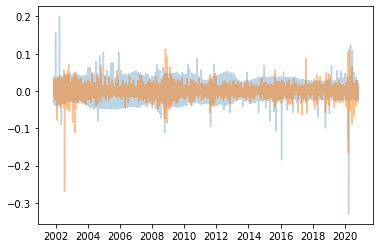

In [ ]:
plt.plot(predicted_returns['ADP'],alpha = .3)
plt.plot(actual_returns['ADP'],alpha = .5)
plt.show()

Comparing the predicted returns(orange) to the actual returns(blue) for AAPL

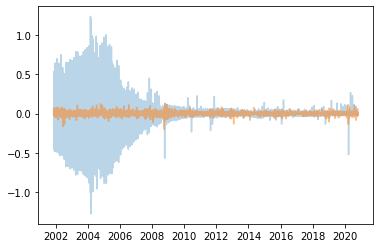

In [ ]:
plt.plot(predicted_returns['AAPL'],alpha = .3)
plt.plot(actual_returns['AAPL'],alpha = .5)
plt.show()

Heuristic for how 'accurately' the model predicts positive/negative returns over the course of the dataset

In [ ]:
temp1 = predicted_returns.to_numpy()
temp2 = actual_returns.to_numpy()

In [ ]:
correct_counter = 0
total = 0
for j in range(predicted_returns.shape[1]):
  stock = j
  for i in range(temp1.shape[0]):
    if(temp1[i,stock] >= 0 and temp2[i, stock] >=0):
      correct_counter+=1
      total+=1
    elif(temp1[i,stock] < 0 and temp2[i, stock] < 0):
      correct_counter+=1
      total+=1
    else:
      total+=1

In [ ]:
print("Correct: ", correct_counter)
print("Wrong: " , total-correct_counter)
print("%Correct ", correct_counter/total)

Correct:  911039
Wrong:  910719
%Correct  0.5000878272525769


# Creation of subsamples

### Function

In [ ]:
from datetime import timedelta
from dateutil.parser import parse

def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    new_date = (date.replace(day=d,month=m, year=y))
    return parse(new_date.strftime('%Y-%m-%d'))

def epochGenerator (dataframe, lookback, horizon,
                    step, cummulative = False):

#takes pandas dataframe with DatetimeIndex

    if cummulative:
        c = lookback
        step = horizon
        
    initial = min(dataframe.index)
    windows = []
    horizons = []

    while initial <= monthdelta(max(dataframe.index), -lookback):
        windowStart = initial
        windowEnd = monthdelta(windowStart, lookback)
        if cummulative:
            windowStart = min(dataframe.index)
            windowEnd = monthdelta(windowStart, c) + timedelta(days=1)
            c += horizon
        horizonStart = windowEnd + timedelta(days=1)
        horizonEnd = monthdelta(horizonStart, horizon)

        lookbackWindow = dataframe[windowStart:windowEnd]
        horizonWindow = dataframe[horizonStart:horizonEnd]

        windows.append(lookbackWindow)
        horizons.append(horizonWindow)

        initial = monthdelta(initial, step)

    return windows, horizons

### Subsamples by month for actual and predicted returns 

In [ ]:
actual_windows, actual_horizons = epochGenerator(actual_returns, 12, 1, 1)
predicted_windows, predicted_horizons = epochGenerator(predicted_returns, 12,1,1)

In [ ]:
actual_windows[0].shape

(253, 382)

# Stock Allocation: Scipy Optimize (Method 1)
- Aux functions (Mean Returns)
- Solving for portfolio weights

In [ ]:
#Mean Returns function
def mean_returns(df, length): 
  mu = df.sum(axis = 0)/length
  return mu

### Optimizing for this predicted portfolio
- Using the predicted stock prices, what would be the optimal weight/ratio of the portfolio that would give the maximum return/minimal variance? 

### Version for predicted stock prices

**Actual Returns**  
Actual returns signifies the returns that we would have actually generated based on the weights calculated with the *predicted stock prices*

**Predicted Returns**   
Predicted returns signifies the returns that we predict that we will generate based on the stock prices

**Why calculate predicted stock prices?**  
If the stock prices can be accurately predicted, we can anticipate which stocks will rise and decline - thus we can place a heavier weighting on the best performing stocks


In [ ]:
from scipy.optimize import minimize, Bounds, LinearConstraint
from numpy.linalg import norm

def actual_return(actual_returns, w):
  actual_returns = actual_returns
  mean_return = mean_returns(actual_returns, actual_returns.shape[0])
  actual_covariance = actual_returns.cov()

  portfolio_returns = mean_return.T.dot(w)
  portfolio_variance = w.T.dot(actual_covariance).dot(w)
  return portfolio_returns, portfolio_variance


#Input entire predicted returns df, starting date, and length to hold portfolio (forwards)
def optimize_weights(predicted_returns, actual_returns, lam1, lam2):
  mean_return = mean_returns(predicted_returns, predicted_returns.shape[0])
  predicted_covariance = predicted_returns.cov()
  
  #Cost Function
  def f(w):
    return -(mean_return.T.dot(w) - lam1*(w.T.dot(predicted_covariance).dot(w)) + lam2*norm(w, ord=1))
  
  #Bounds of Weights
  opt_bounds = Bounds(0, 1)

  #Equality Constraints
  def h(w):
    return sum(w) - 1

  #Constraints Dictionary
  cons = ({
      'type' : 'eq',
      'fun' : lambda w: h(w)
  })

  #Solver
  sol = minimize(f,
                 x0 = np.ones(mean_return.shape[0]),
                 constraints = cons,
                 bounds = opt_bounds,
                 options = {'disp': False},
                 tol=10e-10)


  #Predicted Results
  w = sol.x
  predicted_portfolio_returns = w.dot(mean_return)
  portfolio_STD = w.T.dot(predicted_covariance).dot(w)
  
  #Actual Results
  portfolio_actual_returns, portfolio_actual_variance = actual_return(actual_returns, w)

  ret_dict = {'weights' : w,
              'predicted_returns' : predicted_portfolio_returns,
              'predicted_variance' : portfolio_STD,
              'actual_returns' : portfolio_actual_returns,
              'actual_variance' : portfolio_actual_variance}
  
  return ret_dict

In [ ]:
act_rets = []
pred_rets = []
act_var  = []
pred_var = []

for i in range(20):
  opt = optimize_weights(predicted_horizons[i], actual_horizons[i], 0 , 0)
  act_rets.append(opt['actual_returns'])
  pred_rets.append(opt['predicted_returns'])
  act_var.append(opt['actual_variance'])
  pred_var.append(opt['predicted_variance'])
  print("Horizon", i)

In [ ]:
timestamps = []
for i in range(20):
  time = actual_horizons[i].index[0]
  timestamps.append(time)

act_rets = pd.DataFrame(data = act_rets, columns = ['Returns'], index=timestamps)
pred_rets = pd.DataFrame(data = pred_rets, columns = ['Returns'], index=timestamps)

## Diagnostics Plots

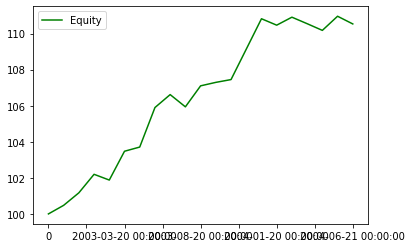

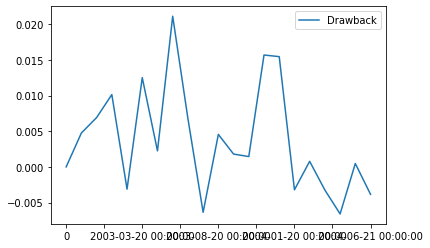

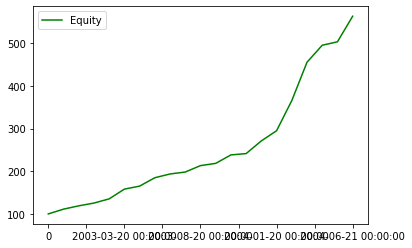

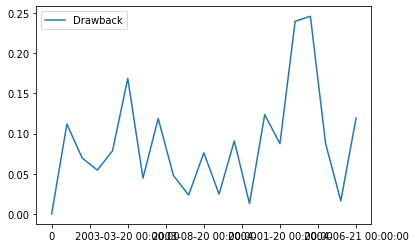

In [ ]:
diagnostics(act_rets, False)
diagnostics(pred_rets, True)

### Tangent Code: Version for non-predicted stock prices

In [ ]:
# from scipy.optimize import minimize, Bounds, LinearConstraint
# from numpy.linalg import norm

# #Input entire predicted returns df, starting date, and length to hold portfolio (forwards)
# def optimize_weights(predicted_returns, lam1, lam2, start, forwards):
#   predicted_returns = predicted_returns.iloc[start:start+forwards,:] 
#   mean_return = mean_returns(predicted_returns, forwards)
#   predicted_covariance = predicted_returns.cov()
  
#   #Cost Function
#   def f(w):
#     return -(mean_return.T.dot(w) - lam1*(w.T.dot(predicted_covariance).dot(w)) + lam2*norm(w, ord=1))
  
#   #Bounds of Weights
#   opt_bounds = Bounds(0, 1)

#   #Equality Constraints
#   def h(w):
#     return sum(w) - 1

#   #Constraints Dictionary
#   cons = ({
#       'type' : 'eq',
#       'fun' : lambda w: h(w)
#   })

#   #Solver
#   sol = minimize(f,
#                  x0 = np.ones(mean_return.shape[0]),
#                  constraints = cons,
#                  bounds = opt_bounds,
#                  options = {'disp': False},
#                  tol=10e-10)


#   #Train Results
#   w = sol.x
#   portfolio_returns = w.dot(mean_return)
#   portfolio_STD = w.T.dot(predicted_covariance).dot(w)
#   return w

# w = optimize_weights(predicted_returns,.5, 1, 10, 30)


# def actual_return(actual_returns, w, start, forwards):
#   actual_returns = actual_returns.iloc 
#   mean_return = mean_returns(actual_returns, forwards)
#   actual_covariance = actual_returns.cov()

#   portfolio_returns = mean_return.T.dot(w)
#   return portfolio_returns

### Performance
- Given $1000, how much would the portfolio grow/decline over 10+ years?
- How does this compare to investing in the S&P 500?

In [ ]:
# portfolio_value = 1000
starting_day = 500
last_day = 200
portfolio_values = [1000]
growth_list = []

for i in range(1,int(last_day/30)):
  w = optimize_weights(predicted_returns, .5, 100, starting_day, 30)
  growth = actual_return(actual_returns, w, starting_day, 30)
  print(" Month: ",  int(starting_day/30)+1, '/' , int(last_day/30))
  print("Growth: ", (1+growth))
  print()
  growth_list.append(growth)
  portfolio_values.append(portfolio_values[i-1] * (1+growth))
  starting_day += 30

 Month:  17 / 6
Growth:  1.0054748107442544

 Month:  18 / 6
Growth:  1.0023562286404095

 Month:  19 / 6
Growth:  1.0000918573607265

 Month:  20 / 6
Growth:  1.0060851925419554

 Month:  21 / 6
Growth:  1.002775898115298



In [ ]:
portfolio_values

[1000,
 1005.4749398142449,
 1007.844123710791,
 1007.9361381434591,
 1014.0696236140569,
 1016.8847154273697]

# Stock Allocation: Montecarlo Simulation (Method 2)

In [ ]:
def Montecarlo(train_dataset):
  Rf = 0 #risk free
  n = 100000 # total portfolios
  np.random.seed(11304)
  W = np.zeros((n,len(train_dataset.columns))) #will store asset allocation for each of the portfolios
  Rp = np.zeros(n) #  will  store returns(daily) for each of the portfolios
  std = np.zeros(n) # will store std for each of the portfolios
  SR = np.zeros(n) # will store sharpe ratios for each of the portfolios
  for i in range(n):
      #w = np.random.random(382) #random weights for each of the stocks
      #w = w /np.sum(w)  
      w = np.random.dirichlet(np.ones(382),size=1)
      
      w = w[0]     
      W[i,:] = w # add to the asset allocation array 
      Rp[i] = (train_dataset.mean().dot(w)).sum()        
      std[i] = np.sqrt(np.dot(w.T, np.dot(train_dataset.cov(),w))) # 252 trading days
      SR[i] = (Rp[i]-Rf)/std[i]


  return {'Return of the Portfolio': Rp,
            'Standard Deviation': std,
            'Sharpe Ratio Achieved':SR,
            'Weights':W}

In [ ]:
n  = 10000
MC = Montecarlo(actual_windows[0])
SR_max = max(MC['Sharpe Ratio Achieved'])
max_index = np.where(MC['Sharpe Ratio Achieved'] == SR_max)
print("We randomly generated %d portfolios chosing different weigths for each of the 382 stocks."%n)
print("Out of those", n ,"portfolios, the most efficient one reached a Sharpe Ratio of", SR_max, ".")
print("It used the following asset allocation:")
print(MC['Return of the Portfolio'][max_index])

We randomly generated 10000 portfolios chosing different weigths for each of the 382 stocks.
Out of those 10000 portfolios, the most efficient one reached a Sharpe Ratio of -0.02047478606810829 .
It used the following asset allocation:
[-0.00029764]


In [ ]:
actual_windows[0].mean()

Index
A      -0.002317
AAPL   -0.000708
ABC     0.000690
ABMD   -0.006793
ABT    -0.000801
          ...   
XRAY    0.000789
XRX     0.000179
YUM    -0.000622
ZBRA    0.000810
ZION   -0.000786
Length: 382, dtype: float64

In [ ]:
#-----------Intentionally Left Blank---------------#






































# Diagnostics Function for Above Code

Includes...
- Equity Graph: *How much money would we make using our techniques?*
- Drawbacks: *How much do we lose when our portfolio dips?*

In [ ]:
def diagnostics(returns, is_pred): 
    if(is_pred == True):
      col = 'red'
    else:
      col = 'green'

    #Takes dataframe with DateIndex and Returns as only column
    
    #Add row for calculation purpose
    starting_point = pd.DataFrame([0], columns=['Returns'])
    equity = starting_point.append(returns)
    
    #-------------------Equity Graph-------------------#
    '''Lazy way of Calculating Equity Value -- refactor if time allows 
    #Equity Val[t] = EquityVal[t-1] * (1 + returns[t])
    #Equity Val[t=0] = 100 '''
    returns_list = equity['Returns'].tolist()
    equities = [0] * len(equity)
    equities[0] = 100
    for i in range(1, len(returns_list)): 
        equities[i] = equities[i-1] * (1 + returns_list[i])
   
    equity['Equity'] = equities 
    equity.plot(y='Equity' , color = 'green')
    
    #---------------------Drawbacks---------------------#
    '''
    Measure of PAIN 
    Drawback is the percentage loss from your previous all time high 
    Drawback = -(PrevEQ_max - currEQ)/PrevEQ_max
    Note that most time a portfolio is in a drawdown 
    What matters is how DEEP and how LONG until you are back up
    '''
    
    rolling_max = [0] * len(equities)
    for i in range(1, len(equities)):
        rolling_max[i] = max(equities[:i]) 
    
    drawbacks = [0] * len(equities)
    for i in range(1, len(equities)):
        drawbacks[i] = -(rolling_max[i] - equities[i])/rolling_max[i]
        
    #Always important to keep track of max Drawback i.e How deep 
    max_Drawback = max(drawbacks)
    
    equity['Drawback'] = drawbacks
    equity.plot(y='Drawback')

# Paper Layout

### Data Manipulation
##### Data Gathering
- Calculate Returns(Discrete/Simple & Log Returns)
- Standardize log returns    

##### Train/Split
- [0+lookback : Last Day]
- Lookback = 1 year
- Hold = 1 month

### Base Models (Model 1)
- Montecarlo, Scipy optimize & Gradient Descent
- Optimize for min variance/Sharpe ratio
- Loss function derivation
- *Uses historical mean returns to predict the future*
- Inputs : Standarized log returns
- Outputs: Weights @each timestep

### Predicting Stock Prices (Model 1 extension)
- LSTM model to predict stock prices
- Normalizes stock prices
- Predict future prices
- Calculate returns as done previously (log returns)
- *The effectiveness of predicting the stock prices*
- LSTM Input: Standardized stock prices
- LSTM Output: Predicted Stock Prices
- Apply 3 base models & compare


